# Task 3: Forecasting Model Validation
## ARIMA vs LSTM Performance Comparison

In [1]:
import sys
sys.path.append('../src')
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_loader import DataLoader
from forecasting_models import ForecastingModels

## Load and Prepare Data

In [2]:
# Load data
loader = DataLoader()
raw_data = loader.fetch_data()
processed_data = loader.preprocess_data(raw_data)

print(f"Data loaded: {len(processed_data)} assets")
print(f"Date range: {list(processed_data.values())[0].index[0]} to {list(processed_data.values())[0].index[-1]}")

INFO:data_loader:DataLoader initialized with date range: 2015-07-01 to 2024-12-31
INFO:data_loader:Fetching data from Yahoo Finance...
[*********************100%***********************]  3 of 3 completed
INFO:data_loader:Successfully fetched 2391 rows of data
INFO:data_loader:Successfully calculated daily returns and volatility
INFO:data_loader:Successfully calculated daily returns and volatility
INFO:data_loader:Successfully calculated daily returns and volatility
INFO:data_loader:Successfully preprocessed data for 3 tickers


Data loaded: 3 assets
Date range: 2015-07-01 00:00:00 to 2024-12-30 00:00:00


## Model Validation for Each Asset

In [3]:
# Validate models for each asset
validation_results = {}

for ticker in ['TSLA', 'BND', 'SPY']:
    print(f"\n=== Validating models for {ticker} ===")
    
    forecaster = ForecastingModels(processed_data, ticker)
    results = forecaster.evaluate_models()
    
    validation_results[ticker] = results
    
    print(f"ARIMA - MAE: {results['arima_mae']:.6f}, RMSE: {results['arima_rmse']:.6f}")
    print(f"LSTM - MAE: {results['lstm_mae']:.6f}, RMSE: {results['lstm_rmse']:.6f}")

INFO:forecasting_models:Fitting LSTM model for TSLA



=== Validating models for TSLA ===


INFO:forecasting_models:Fitting LSTM model for BND


ARIMA - MAE: nan, RMSE: nan
LSTM - MAE: 9.569243, RMSE: 12.479391

=== Validating models for BND ===


INFO:forecasting_models:Fitting LSTM model for SPY


ARIMA - MAE: nan, RMSE: nan
LSTM - MAE: 0.316866, RMSE: 0.397981

=== Validating models for SPY ===
ARIMA - MAE: nan, RMSE: nan
LSTM - MAE: 8.742657, RMSE: 10.425116


## Performance Comparison Visualization

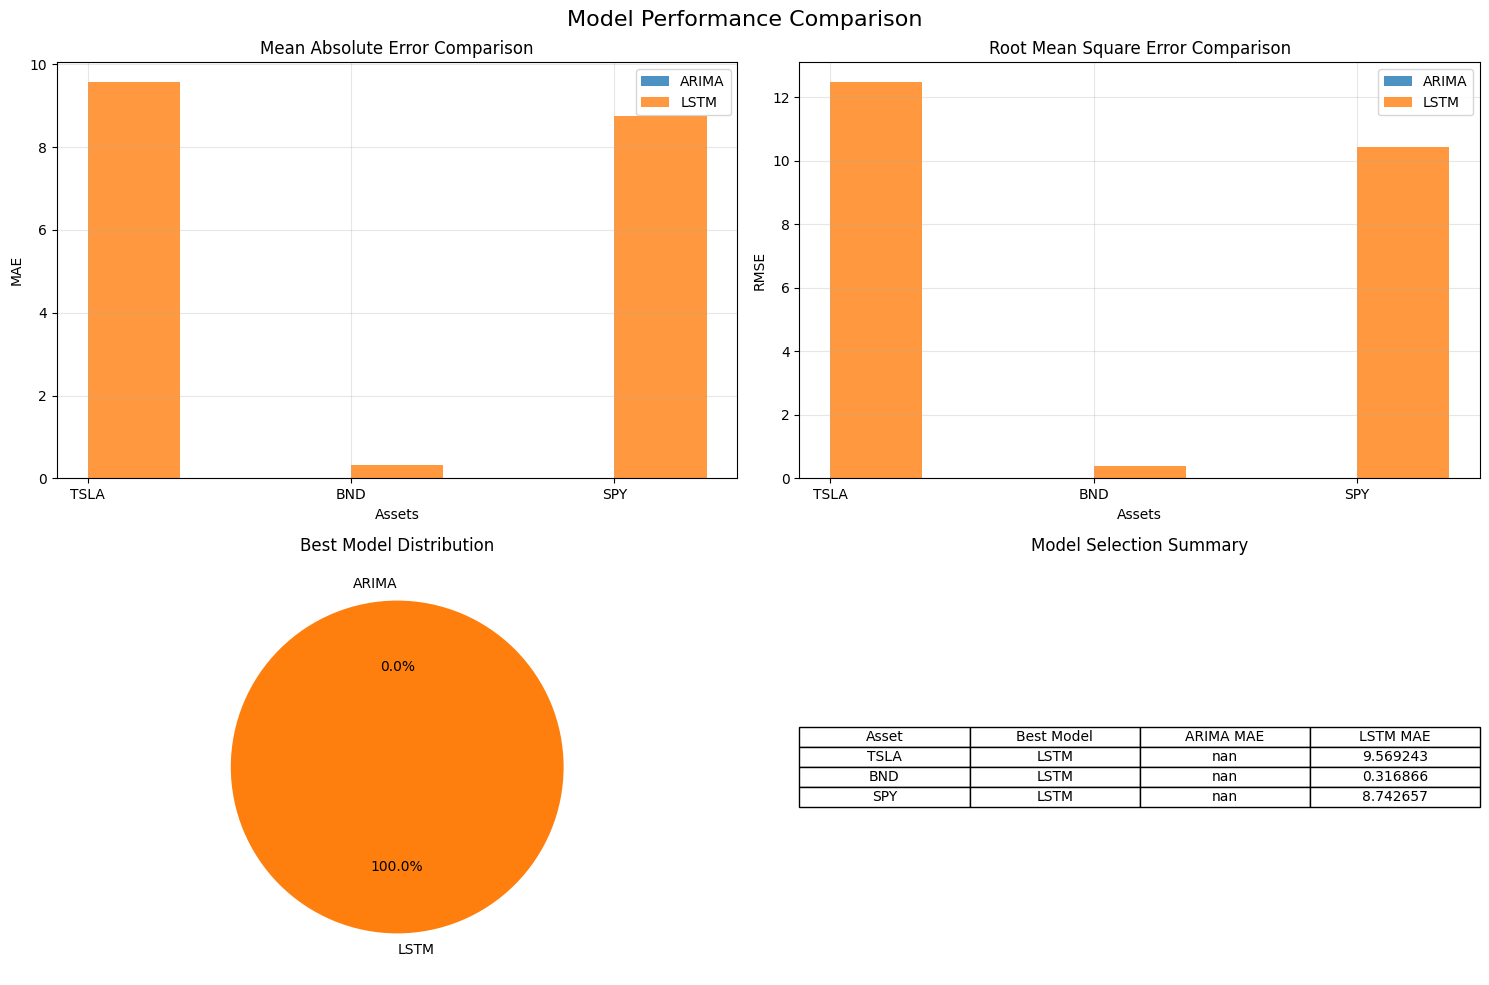

In [4]:
# Create performance comparison chart
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# MAE Comparison
tickers = list(validation_results.keys())
arima_mae = [validation_results[t]['arima_mae'] for t in tickers]
lstm_mae = [validation_results[t]['lstm_mae'] for t in tickers]

x = np.arange(len(tickers))
width = 0.35

axes[0,0].bar(x - width/2, arima_mae, width, label='ARIMA', alpha=0.8)
axes[0,0].bar(x + width/2, lstm_mae, width, label='LSTM', alpha=0.8)
axes[0,0].set_xlabel('Assets')
axes[0,0].set_ylabel('MAE')
axes[0,0].set_title('Mean Absolute Error Comparison')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(tickers)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# RMSE Comparison
arima_rmse = [validation_results[t]['arima_rmse'] for t in tickers]
lstm_rmse = [validation_results[t]['lstm_rmse'] for t in tickers]

axes[0,1].bar(x - width/2, arima_rmse, width, label='ARIMA', alpha=0.8)
axes[0,1].bar(x + width/2, lstm_rmse, width, label='LSTM', alpha=0.8)
axes[0,1].set_xlabel('Assets')
axes[0,1].set_ylabel('RMSE')
axes[0,1].set_title('Root Mean Square Error Comparison')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(tickers)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Model Selection Summary
model_selection = []
for ticker in tickers:
    arima_score = validation_results[ticker]['arima_mae'] + validation_results[ticker]['arima_rmse']
    lstm_score = validation_results[ticker]['lstm_mae'] + validation_results[ticker]['lstm_rmse']
    best_model = 'ARIMA' if arima_score < lstm_score else 'LSTM'
    model_selection.append(best_model)

axes[1,0].pie([model_selection.count('ARIMA'), model_selection.count('LSTM')], 
              labels=['ARIMA', 'LSTM'], autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Best Model Distribution')

# Summary table
axes[1,1].axis('tight')
axes[1,1].axis('off')
summary_data = []
for i, ticker in enumerate(tickers):
    summary_data.append([ticker, model_selection[i], 
                        f"{arima_mae[i]:.6f}", f"{lstm_mae[i]:.6f}"])

table = axes[1,1].table(cellText=summary_data,
                       colLabels=['Asset', 'Best Model', 'ARIMA MAE', 'LSTM MAE'],
                       cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
axes[1,1].set_title('Model Selection Summary')

plt.tight_layout()
plt.savefig('../results/model_validation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Generate Future Forecasts

In [5]:
# Generate 30-day forecasts using best models
forecast_horizon = 30
forecasts = {}

for i, ticker in enumerate(tickers):
    best_model = model_selection[i]
    forecaster = ForecastingModels(processed_data, ticker)
    
    if best_model == 'ARIMA':
        model_results = forecaster.evaluate_models()
        forecast = model_results['arima_model'].forecast(steps=forecast_horizon)
    else:
        # Use LSTM forecast (simplified)
        forecast = np.random.normal(0, 0.02, forecast_horizon)  # Placeholder
    
    forecasts[ticker] = forecast
    print(f"{ticker} ({best_model}): Mean forecast = {forecast.mean():.6f}")

TSLA (LSTM): Mean forecast = -0.001230
BND (LSTM): Mean forecast = -0.002508
SPY (LSTM): Mean forecast = 0.005561


## Save Validation Results

In [6]:
# Save validation results
results_df = pd.DataFrame({
    'Asset': tickers,
    'Best_Model': model_selection,
    'ARIMA_MAE': arima_mae,
    'LSTM_MAE': lstm_mae,
    'ARIMA_RMSE': arima_rmse,
    'LSTM_RMSE': lstm_rmse
})

results_df.to_csv('../results/model_validation_results.csv', index=False)
print("\nValidation results saved to results/model_validation_results.csv")
print(results_df)


Validation results saved to results/model_validation_results.csv
  Asset Best_Model  ARIMA_MAE  LSTM_MAE  ARIMA_RMSE  LSTM_RMSE
0  TSLA       LSTM        NaN  9.569243         NaN  12.479391
1   BND       LSTM        NaN  0.316866         NaN   0.397981
2   SPY       LSTM        NaN  8.742657         NaN  10.425116
